In [54]:
from SmartApi.smartConnect import SmartConnect
import pyotp
import pandas as pd
import requests
import pandas as pd
from datetime import datetime, timedelta
from datetime import datetime, timedelta
import pandas_ta as ta
import numpy as np

api_key = 'C46AImmE'
clientId = 'M507690'
pwd = '4663'
smartApi = SmartConnect(api_key)
token = "4ACNNSIZL6EV6UQ2ACSI23H5VQ"
totp=pyotp.TOTP(token).now()
correlation_id = "abc123"

# login api call

data = smartApi.generateSession(clientId, pwd, totp)
# print(data)
authToken = data['data']['jwtToken']
refreshToken = data['data']['refreshToken']

# fetch the feedtoken
feedToken = smartApi.getfeedToken()

# fetch User Profile
res = smartApi.getProfile(refreshToken)
smartApi.generateToken(refreshToken)
res=res['data']['exchanges']

#fetch User Profile
userProfile= smartApi.getProfile(refreshToken)
User= pd.DataFrame(userProfile)
User = User['data']['name']
User
print(f"Welcome {User} to the World of SMART API BY ANGEL.....!!")
print(f"Login Sucessfull....!!")


[I 251225 13:23:05 smartConnect:124] in pool


Welcome MANA  BHATTACHARYYA to the World of SMART API BY ANGEL.....!!
Login Sucessfull....!!


In [55]:
# ---- NIFTY 50 Token (Angel One Fixed Token) ----
NIFTY_TOKEN = "26000"      # NIFTY 50 Index
EXCHANGE = "NSE"

# ---- Fetch LTP ----
ltp_data = smartApi.ltpData(
    exchange=EXCHANGE,
    tradingsymbol="NIFTY",
    symboltoken=NIFTY_TOKEN
)

print("📈 NIFTY 50 LTP:", ltp_data['data']['ltp'])

ATM = round(ltp_data['data']['ltp'] / 50) * 50
print("📈 NIFTY 50 SPOT Price:", ATM)

ltp =  ltp_data['data']['ltp']
prev_close = ltp_data['data']['close']

change = ltp - prev_close
pct_change = (change / prev_close) * 100

print(f"NIFTY Change: {change:.2f}")
print(f"NIFTY % Change: {pct_change:.2f}%")


📈 NIFTY 50 LTP: 26142.1
📈 NIFTY 50 SPOT Price: 26150
NIFTY Change: -35.05
NIFTY % Change: -0.13%


In [56]:
# ---------- FETCH 5-MIN CANDLES ---------- #
to_date = datetime.now()
from_date = to_date - timedelta(days=1400)

params = {
    "exchange": "NSE",
    "symboltoken": "99926000",
    "interval": "ONE_DAY",
    "fromdate": from_date.strftime("%Y-%m-%d %H:%M"),
    "todate": to_date.strftime("%Y-%m-%d %H:%M")
}

data = smartApi.getCandleData(params)
NIFTY = pd.DataFrame(
    data["data"],
    columns=["Datetime", "Open", "High", "Low", "Close", "Volume"]
)
NIFTY["Datetime"] = pd.to_datetime(NIFTY["Datetime"])
NIFTY['Datetime'] = pd.to_datetime(NIFTY['Datetime']).dt.tz_localize(None)
NIFTY['NIFTY_Change'] = NIFTY['Close'].diff()
NIFTY.tail(5)

,Datetime,Open,High,Low,Close,Volume,NIFTY_Change
945,2025-12-18,25764.70,25902.35,25726.30,25815.55,0,-3.00
946,2025-12-19,25911.50,25993.35,25880.45,25966.40,0,150.85
947,2025-12-22,26055.85,26180.70,26047.80,26172.40,0,206.00
948,2025-12-23,26205.20,26233.55,26119.05,26177.15,0,4.75
949,2025-12-24,26170.65,26236.40,26123.00,26142.10,0,-35.05


In [57]:
# -----------------------------
# 1️⃣ LOG RETURN VOLATILITY
# -----------------------------
df = NIFTY
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df['volatility_20'] = df['log_return'].rolling(20).std() * np.sqrt(252)

# -----------------------------
# 2️⃣ TRUE RANGE & ATR
# -----------------------------
df['tr1'] = df['High'] - df['Low']
df['tr2'] = (df['High'] - df['Close'].shift()).abs()
df['tr3'] = (df['Low'] - df['Close'].shift()).abs()

df['TR'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)
df['ATR_14'] = df['TR'].rolling(14).mean()

# -----------------------------
# 3️⃣ PARKINSON VOLATILITY (HL)
# -----------------------------
df['parkinson_vol'] = (
    (np.log(df['High'] / df['Low']) ** 2)
    .rolling(20)
    .mean()
    / (4 * np.log(2))
)

df['parkinson_vol'] = np.sqrt(df['parkinson_vol']) * np.sqrt(252)

# -----------------------------
# 4️⃣ GARMAN-KLASS VOLATILITY (OHLC)
# -----------------------------
df['gk_vol'] = (
    0.5 * (np.log(df['High'] / df['Low']) ** 2)
    - (2 * np.log(2) - 1) * (np.log(df['Close'] / df['Open']) ** 2)
)

df['gk_vol'] = np.sqrt(df['gk_vol'].rolling(20).mean()) * np.sqrt(252)

# -----------------------------
# 5️⃣ BOLLINGER BAND WIDTH
# -----------------------------
df['SMA20'] = df['Close'].rolling(20).mean()
df['BB_std'] = df['Close'].rolling(20).std()
df['BB_width'] = (2 * df['BB_std']) / df['SMA20']

# -----------------------------
# 6️⃣ RSI VOLATILITY (OPTIONAL)
# -----------------------------
if 'RSI' in df.columns:
    df['RSI_vol'] = df['RSI'].rolling(14).std()
else:
    df['RSI_vol'] = np.nan

# -----------------------------
# 7️⃣ VOLATILITY REGIME
# -----------------------------
df['vol_regime'] = np.where(
    df['ATR_14'] > df['ATR_14'].rolling(50).mean(),
    'HIGH_VOL',
    'LOW_VOL'
)

# -----------------------------
# 8️⃣ FINAL FEATURE SET
# -----------------------------
volatility_features = [
    'volatility_20',
    'ATR_14',
    'parkinson_vol',
    'gk_vol',
    'BB_width',
    'RSI_vol',
    'vol_regime'
]
df.tail(2)

,Datetime,Open,High,Low,Close,Volume,NIFTY_Change,log_return,volatility_20,tr1,...,tr3,TR,ATR_14,parkinson_vol,gk_vol,SMA20,BB_std,BB_width,RSI_vol,vol_regime
948,2025-12-23,26205.20,26233.55,26119.05,26177.15,0,4.75,0.000181,0.083669,114.5,...,53.35,114.5,191.557143,0.069644,0.066709,26018.955,151.910846,0.011677,NaN,LOW_VOL
949,2025-12-24,26170.65,26236.40,26123.00,26142.10,0,-35.05,-0.001340,0.071383,113.4,...,54.15,113.4,188.278571,0.063295,0.064946,26015.795,148.448417,0.011412,NaN,LOW_VOL


In [58]:
def normalize(series, window=100):
    rolling_min = series.rolling(window).min()
    rolling_max = series.rolling(window).max()
    return (series - rolling_min) / (rolling_max - rolling_min)

# -----------------------------
# NORMALIZE COMPONENTS
# -----------------------------
df['ATR_norm'] = normalize(df['ATR_14'])
df['Parkinson_norm'] = normalize(df['parkinson_vol'])
df['BB_norm'] = normalize(df['BB_width'])
df['ReturnVol_norm'] = normalize(df['volatility_20'])

# -----------------------------
# WEIGHTS (Tuned for Index Trading)
# -----------------------------
W_ATR = 0.35
W_PARK = 0.30
W_BB = 0.20
W_RET = 0.15

# -----------------------------
# VOLATILITY SCORE (0–100)
# -----------------------------
df['Volatility_Score'] = (
    W_ATR * df['ATR_norm'] +
    W_PARK * df['Parkinson_norm'] +
    W_BB * df['BB_norm'] +
    W_RET * df['ReturnVol_norm']
) * 100

# -----------------------------
# CLEANUP
# -----------------------------
df['Volatility_Score'] = df['Volatility_Score'].clip(0, 100)
df.tail(2)

,Datetime,Open,High,Low,Close,Volume,NIFTY_Change,log_return,volatility_20,tr1,...,SMA20,BB_std,BB_width,RSI_vol,vol_regime,ATR_norm,Parkinson_norm,BB_norm,ReturnVol_norm,Volatility_Score
948,2025-12-23,26205.20,26233.55,26119.05,26177.15,0,4.75,0.000181,0.083669,114.5,...,26018.955,151.910846,0.011677,NaN,LOW_VOL,0.573518,0.388318,0.070631,0.464670,40.105349
949,2025-12-24,26170.65,26236.40,26123.00,26142.10,0,-35.05,-0.001340,0.071383,113.4,...,26015.795,148.448417,0.011412,NaN,LOW_VOL,0.533560,0.085367,0.060266,0.136848,24.493621


In [59]:
df['future_return_10'] = df['Close'].shift(-10) / df['Close'] - 1
df['signal'] = 0
df.loc[df['future_return_10'] > 0.03, 'signal'] = 1   # BUY
df.loc[df['future_return_10'] < -0.03, 'signal'] = -1 # SELL

df.tail(2)

,Datetime,Open,High,Low,Close,Volume,NIFTY_Change,log_return,volatility_20,tr1,...,BB_width,RSI_vol,vol_regime,ATR_norm,Parkinson_norm,BB_norm,ReturnVol_norm,Volatility_Score,future_return_10,signal
948,2025-12-23,26205.20,26233.55,26119.05,26177.15,0,4.75,0.000181,0.083669,114.5,...,0.011677,NaN,LOW_VOL,0.573518,0.388318,0.070631,0.464670,40.105349,NaN,0
949,2025-12-24,26170.65,26236.40,26123.00,26142.10,0,-35.05,-0.001340,0.071383,113.4,...,0.011412,NaN,LOW_VOL,0.533560,0.085367,0.060266,0.136848,24.493621,NaN,0


In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)
target_corr = corr['future_return_10'].sort_values(ascending=False)

print(target_corr)


future_return_10    1.000000
signal              0.803164
BB_norm             0.204009
ReturnVol_norm      0.141833
BB_width            0.113840
TR                  0.110437
Volatility_Score    0.106606
tr3                 0.104156
BB_std              0.088913
tr1                 0.070679
tr2                 0.065673
ATR_norm            0.060355
volatility_20       0.040497
parkinson_vol       0.020034
Parkinson_norm      0.019859
gk_vol              0.011501
ATR_14              0.007527
log_return         -0.031066
NIFTY_Change       -0.038969
SMA20              -0.061978
High               -0.102481
Open               -0.102757
Close              -0.104571
Low                -0.105494
Volume                   NaN
RSI_vol                  NaN
Name: future_return_10, dtype: float64


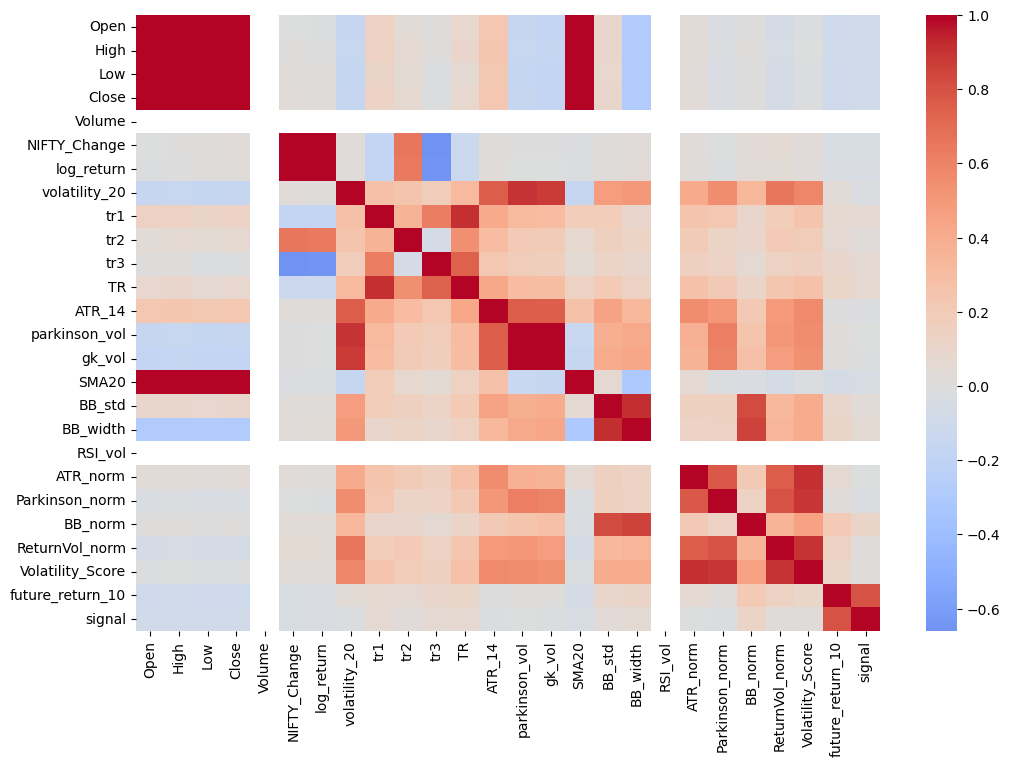

In [61]:
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.show()


In [62]:
df['trend_strength'] = df['Close'] / df['SMA20'] - 1
df['vol_pressure'] = df['BB_width'] * df['ATR_norm']
#df['regime_vol'] = df['vol_regime'] * df['Volatility_Score']



In [63]:
from xgboost import XGBClassifier

features = [
    'log_return','ATR_norm','BB_norm','BB_width',
    'Volatility_Score','trend_strength',
    'vol_pressure'
]

# --- TARGET ---
df['signal_cls'] = 0
df.loc[df['future_return_10'] > 0.03, 'signal_cls'] = 1

# --- DROP NaNs (CRITICAL) ---
model_df = df[features + ['signal_cls']].dropna()

X_cls = model_df[features]
y_cls = model_df['signal_cls']

# --- MODEL ---
model_cls = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    eval_metric='logloss'
)

model_cls.fit(X_cls, y_cls)

# --- PREDICT PROBABILITY ---
df.loc[model_df.index, 'buy_prob'] = model_cls.predict_proba(X_cls)[:, 1]


In [64]:
features = [
    'log_return','ATR_norm','BB_norm','BB_width',
    'Volatility_Score','trend_strength',
    'vol_pressure'
]

missing = [f for f in features if f not in df.columns]
if missing:
    raise ValueError(f"Missing features for regression: {missing}")



if 'future_return_10' not in df.columns:
    df['future_return_10'] = df['Close'].shift(-10) / df['Close'] - 1



from xgboost import XGBRegressor

reg_df = df[features + ['future_return_10']].dropna()

X_reg = reg_df[features]
y_reg = reg_df['future_return_10']

model_reg = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_reg.fit(X_reg, y_reg)

# Assign predictions BACK to df safely
df.loc[reg_df.index, 'pred_return'] = model_reg.predict(X_reg)





In [65]:
df['final_signal'] = 0

df.loc[
    (df['pred_return'] > 0.005) &      # 0.5%
    (df['buy_prob'] > 0.55),
    'final_signal'
] = 1

df.loc[
    (df['pred_return'] < -0.005) &
    (df['buy_prob'] < 0.45),
    'final_signal'
] = -1


In [66]:
df['final_signal'] = 0

df.loc[
    (df['pred_return'] > 0.02) &
    (df['buy_prob'] > 0.65) &
    (df['trend_strength'] > 0),
    'final_signal'
] = 1

df.loc[
    (df['pred_return'] < -0.02) &
    (df['buy_prob'] < 0.35),
    'final_signal'
] = -1

df[['buy_prob']].tail()


,buy_prob
945,0.031239
946,0.022221
947,0.014153
948,0.012741
949,0.058322


In [67]:
df['strategy_return'] = df['final_signal'].shift(1) * df['log_return']
df['cum_strategy'] = (1 + df['strategy_return']).cumprod()
df['cum_nifty'] = (1 + df['log_return']).cumprod()
df.to_csv('NIFTY50_LONG.csv')
df.tail()



,Datetime,Open,High,Low,Close,Volume,NIFTY_Change,log_return,volatility_20,tr1,...,signal,trend_strength,vol_pressure,signal_cls,buy_prob,pred_return,final_signal,strategy_return,cum_strategy,cum_nifty
945,2025-12-18,25764.70,25902.35,25726.30,25815.55,0,-3.00,-0.000116,0.079412,176.05,...,0,-0.007048,0.006896,0,0.031239,NaN,0,-0.0,1.250572,1.501141
946,2025-12-19,25911.50,25993.35,25880.45,25966.40,0,150.85,0.005826,0.081159,112.90,...,0,-0.001050,0.006630,0,0.022221,NaN,0,0.0,1.250572,1.509887
947,2025-12-22,26055.85,26180.70,26047.80,26172.40,0,206.00,0.007902,0.084555,132.90,...,0,0.006463,0.007226,0,0.014153,NaN,0,0.0,1.250572,1.521818
948,2025-12-23,26205.20,26233.55,26119.05,26177.15,0,4.75,0.000181,0.083669,114.50,...,0,0.006080,0.006697,0,0.012741,NaN,0,0.0,1.250572,1.522094
949,2025-12-24,26170.65,26236.40,26123.00,26142.10,0,-35.05,-0.001340,0.071383,113.40,...,0,0.004855,0.006089,0,0.058322,NaN,0,-0.0,1.250572,1.520055


<Axes: >

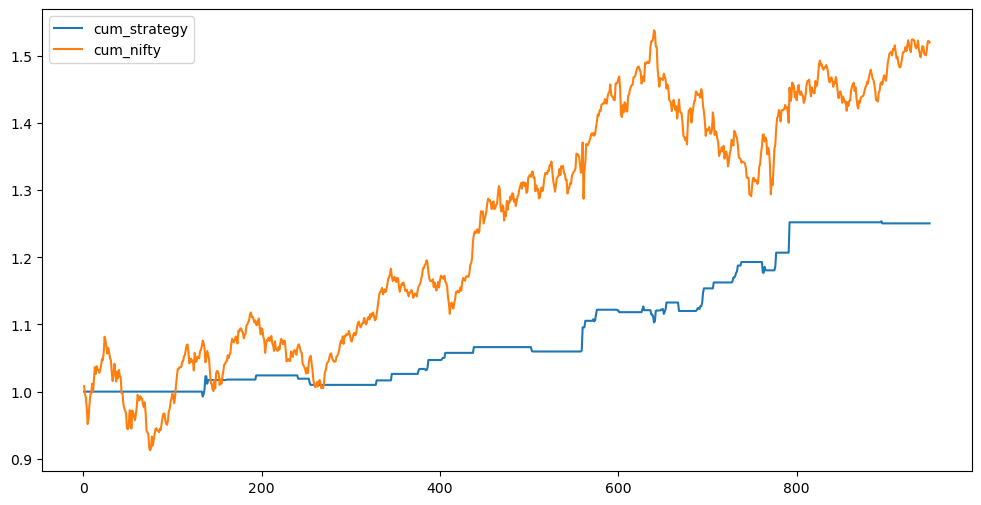

In [68]:
df[['cum_strategy','cum_nifty']].plot(figsize=(12,6))


In [69]:
assert 'buy_prob' in df.columns
assert df['buy_prob'].isna().mean() < 0.3


Initial Capital : ₹100,000
Final Capital   : ₹105,923
Total Profit    : ₹5,923
Return %        : 5.92%

Trade Summary:
Empty DataFrame
Columns: []
Index: []


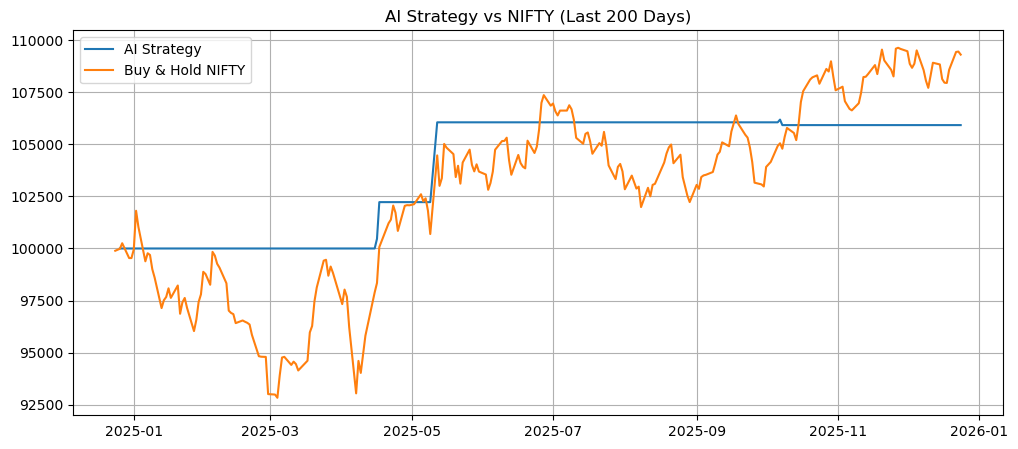

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# PARAMETERS
# ===============================
capital = 100000
lookback_days = 250

# ===============================
# REQUIRED COLUMNS CHECK
# ===============================
required_cols = [
    'Datetime', 'Close', 'log_return', 'final_signal'
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# ===============================
# PREPARE BACKTEST DATA (SAFE)
# ===============================
df_bt = df[required_cols].copy()

# Drop NaN only where necessary
df_bt = df_bt.dropna(subset=['Close', 'log_return', 'final_signal'])

# Use last N days
df_bt = df_bt.iloc[-lookback_days:].copy()

if len(df_bt) == 0:
    raise ValueError("Backtest dataframe is empty")

# ===============================
# POSITION LOGIC (LONG ONLY)
# ===============================
df_bt['position'] = 0

df_bt.loc[df_bt['final_signal'] == 1, 'position'] = 1
df_bt.loc[df_bt['final_signal'] == -1, 'position'] = 0

# Carry forward position
df_bt['position'] = df_bt['position'].ffill().fillna(0)

# ===============================
# RETURNS & EQUITY CURVE
# ===============================
df_bt['strategy_return'] = df_bt['position'].shift(1) * df_bt['log_return']

df_bt['strategy_equity'] = capital * (1 + df_bt['strategy_return']).cumprod()
df_bt['nifty_equity'] = capital * (1 + df_bt['log_return']).cumprod()

# ===============================
# PERFORMANCE METRICS
# ===============================
final_value = df_bt['strategy_equity'].iloc[-1]
profit = final_value - capital
profit_pct = (profit / capital) * 100

print("=" * 50)
print(f"Initial Capital : ₹{capital:,.0f}")
print(f"Final Capital   : ₹{final_value:,.0f}")
print(f"Total Profit    : ₹{profit:,.0f}")
print(f"Return %        : {profit_pct:.2f}%")
print("=" * 50)

# ===============================
# TRADE LOG (BUY → SELL)
# ===============================
trades = []
entry_price = None
entry_date = None

for idx, row in df_bt.iterrows():
    if row['final_signal'] == 1 and entry_price is None:
        entry_price = row['Close']
        entry_date = row['Datetime']

    elif row['final_signal'] == -1 and entry_price is not None:
        exit_price = row['Close']
        pnl_pct = (exit_price - entry_price) / entry_price * 100

        trades.append({
            'Entry Date': entry_date,
            'Exit Date': row['Datetime'],
            'Entry Price': entry_price,
            'Exit Price': exit_price,
            'Profit %': round(pnl_pct, 2)
        })

        entry_price = None
        entry_date = None

trade_df = pd.DataFrame(trades)

print("\nTrade Summary:")
print(trade_df)

# ===============================
# VISUALIZATION
# ===============================
plt.figure(figsize=(12, 5))
plt.plot(df_bt['Datetime'], df_bt['strategy_equity'], label='AI Strategy')
plt.plot(df_bt['Datetime'], df_bt['nifty_equity'], label='Buy & Hold NIFTY')
plt.title('AI Strategy vs NIFTY (Last 200 Days)')
plt.legend()
plt.grid(True)
plt.show()
